In [1]:
# General imports
import numpy as np
np.random.seed(42)
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import sys
import os
import yaml
from resum.utilities import plotting_utils as plotting
from resum.multi_fidelity_gaussian_process import MultiFidelityVisualizer
from resum.multi_fidelity_gaussian_process import MFGPModel
from resum.multi_fidelity_gaussian_process import InequalityConstraints

In [ ]:
with open("./binary-black-hole/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output.csv'


In [ ]:

if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]
x_fixed = config_file["simulation_settings"]["theta_fixed"]
parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]

# Assign costs
low_fidelity_cost = config_file["simulation_settings"]["lf_cost"]
high_fidelity_cost = config_file["simulation_settings"]["lf_cost"]


In [ ]:

data=pd.read_csv(file_in)

In [6]:

LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
row_h=data.index[data['fidelity'] == 1].tolist()
row_l=data.index[data['fidelity'] == 0].tolist()

x_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()

x_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][ y_label_cnp].to_numpy().tolist()

x_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_sim].to_numpy().tolist()

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_cnp].to_numpy().tolist()




In [7]:
trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
noise = {"lf": LF_cnp_noise, "mf": HF_cnp_noise, "hf": 0.}

In [8]:
mf_model = MFGPModel(trainings_data,noise)
mf_model.build_model(10)

 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = -870.4385926180619
Optimization restart 2/10, f = -215.029408351803
Optimization restart 3/10, f = -215.03266220425462
Optimization restart 4/10, f = -215.03043413926076
Optimization restart 5/10, f = -939.7442458329418
Optimization restart 6/10, f = -215.02961031386394
Optimization restart 7/10, f = -215.0301333002248
Optimization restart 8/10, f = -916.2922197193043
Optimization restart 9/10, f = -215.03155866556767
Optimization restart 10/10, f = -795.4624688501034


In [9]:
mf_model.model.gpy_model

gp.,value,constraints,priors
multifidelity.rbf.variance,0.037920405859171724,+ve,
multifidelity.rbf.lengthscale,18676.43775422074,+ve,
multifidelity.rbf_1.variance,8.387581679202108e-67,+ve,
multifidelity.rbf_1.lengthscale,1.4931300202060673e-18,+ve,
multifidelity.rbf_2.variance,2.3267814758695437e-05,+ve,
multifidelity.rbf_2.lengthscale,0.23503848169504307,+ve,
multifidelity.rbf_3.variance,0.7964142895264152,+ve,
multifidelity.rbf_3.lengthscale,1.1290522650070869,+ve,
multifidelity.scale,"(3,)",,
mixed_noise.Gaussian_noise.variance,0.021920000000000002,+ve fixed,


In [10]:
%%capture
leg_label = []
ncol=3
nrow=int(np.ceil(len(x_labels)/ncol))
fig2,_  = plt.subplots(nrow, ncol, figsize=(15, 5), constrained_layout=True)
fig4,_  = plt.subplots(int(np.ceil(len(x_labels)/1)), 1, figsize=(5, 12), constrained_layout=True)



In [11]:
mf_vis = MultiFidelityVisualizer(mf_model,parameters,x_fixed)

In [12]:

sample=0
add_new_sample=True
mf_model.set_traings_data(trainings_data)

while ( sample <= data['iteration'].max()):
    print('Sample #', sample)

    if sample > 0:    
         
        x_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_sim = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_sim].to_numpy().tolist()
        print(f"Adding {x_train_hf_sim}")   
        x_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_hf_cnp = data[(data['fidelity']==1.) & (data['iteration']==sample)][y_label_cnp].to_numpy().tolist()

        x_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][x_labels].to_numpy().tolist()
        y_train_lf_cnp = data[(data['fidelity']==0.) & (data['iteration']==sample)][ y_label_cnp].to_numpy().tolist()
        trainings_data_new = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "mf": [x_train_hf_cnp,y_train_hf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}
        mf_model.set_data(trainings_data_new)


    # run the model drawing
    fig1, ax = plt.subplots(2, 3,figsize=(15, 5),constrained_layout=True)
    fig1 = mf_vis.draw_model_projections(fig1)
    fig2 = mf_vis.draw_model_projections(fig2)

    # find the next data point
    x_next_sample, us_acquisition = mf_model.max_acquisition_integrated_variance_reduction(parameters)
    print(f'next suggested point to simulated is at: {x_next_sample}')
    fig4 = mf_vis.draw_acquisition_func(fig4, us_acquisition, np.array(x_next_sample))
    sample+=1




Sample # 0


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
fig4.savefig(f"{path_out_mfgp}/mfgp_{version}_model_acq.png")

 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_63880/3159846776.py:1: UserWarning:constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.


In [ ]:
%matplotlib inline
fig2.show()
fig4.show()

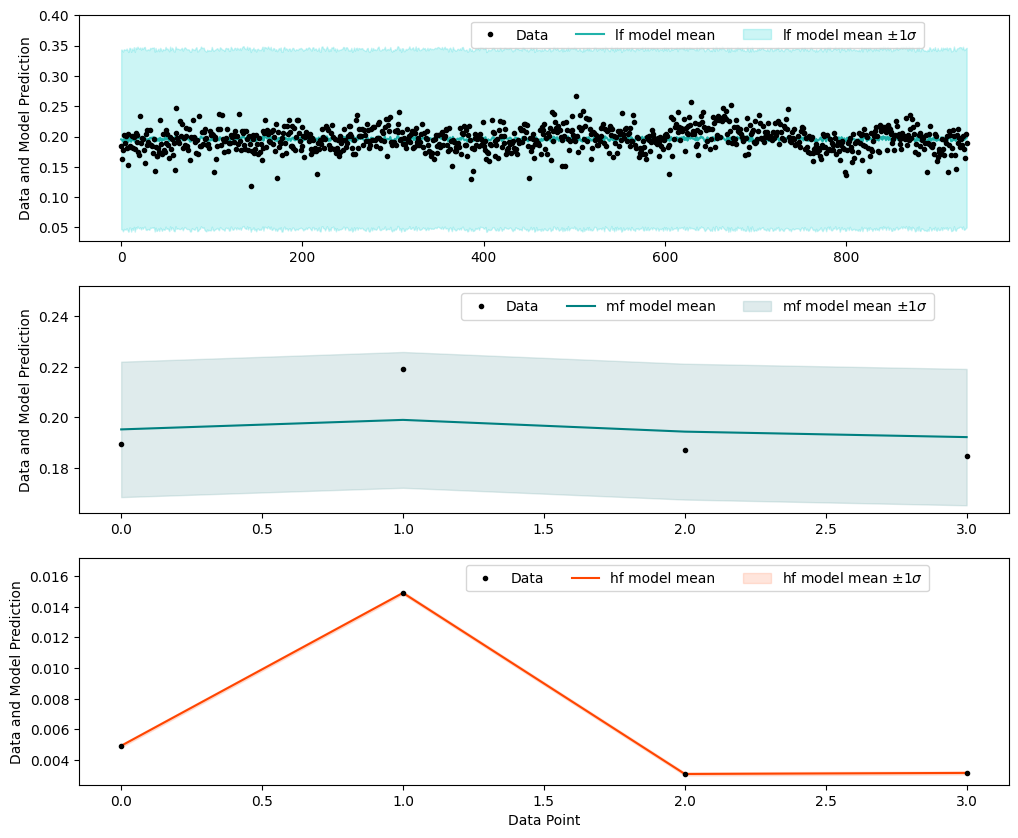

In [ ]:
fig3 = mf_vis.draw_model()

In [ ]:
fig3.savefig(f"{path_out_mfgp}/mfgp_{version}_model.png")

In [ ]:
#data_test=pd.read_csv(f'in/mfgp/hf_validation_data_v1.2.csv')
#x_test = data_test.loc[data_test['Fidelity']==1.][x_labels].to_numpy().tolist()
#y_test = data_test.loc[data_test['Fidelity']==1.][y_label_sim].to_numpy().tolist()
#fig5, validation  = mf_vis.model_validation(x_test, y_test)
#plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'in/mfgp/hf_validation_data_v1.2.csv'